In [1]:
import numpy as np
from functools import partial
import os

import llmize
from llmize import OPRO, HLMEA
import llmize.utils

def initialize_tsp(num_cities, seed=42):
    """
    Initializes the TSP with random city coordinates.
    :param num_cities: Number of cities
    :param seed: Random seed for reproducibility
    :return: Distance matrix
    """
    np.random.seed(seed)
    cities = (np.random.rand(num_cities, 2) * 100).astype(int)  # Random cities in 100x100 space with integer coordinates
    
    # Compute distance matrix
    dist_matrix = np.sqrt(((cities[:, np.newaxis] - cities[np.newaxis, :]) ** 2).sum(axis=2))
    return cities, dist_matrix

def objective_function(route, dist_matrix):
    """
    Computes the total travel distance for a given route.
    :param route: A permutation of city indices representing the tour
    :param dist_matrix: Precomputed distance matrix
    :return: Total distance of the route
    """

    # Check if route is valid
    if len(route) != dist_matrix.shape[0]:
        return 1000

    total_distance = sum(dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))
    total_distance += dist_matrix[route[-1], route[0]]  # Return to starting city
    return total_distance


/home/rizki/llmize/llmize/methods/hlmea.py:84: SyntaxWarning: invalid escape sequence '\s'
  """
/home/rizki/llmize/llmize/methods/hlmea.py:148: SyntaxWarning: invalid escape sequence '\h'
  hp_text = f"""The hyperparameters (elitism_rate, mutation_rate, crossover_rate) used in previous step are: <hp> {hp[0]}, {hp[1]}, {hp[2]} <\hp>"""


In [2]:
num_cities = 10
cities, dist_matrix = initialize_tsp(num_cities)
# generate 5 random routes and total distances
routes = [np.random.permutation(num_cities) for _ in range(16)]
total_distances = [objective_function(route, dist_matrix) for route in routes]

print(np.shape(dist_matrix))
print(routes)
print(total_distances)


(10, 10)
[array([1, 5, 4, 8, 0, 7, 6, 3, 2, 9]), array([8, 2, 5, 7, 3, 1, 9, 0, 4, 6]), array([0, 5, 2, 6, 3, 7, 4, 1, 8, 9]), array([4, 8, 1, 3, 0, 5, 2, 9, 7, 6]), array([2, 0, 4, 9, 8, 6, 7, 5, 1, 3]), array([4, 2, 7, 0, 6, 3, 5, 8, 9, 1]), array([5, 2, 7, 3, 0, 8, 9, 6, 1, 4]), array([1, 5, 2, 4, 3, 7, 9, 6, 8, 0]), array([3, 1, 4, 5, 8, 6, 9, 7, 0, 2]), array([2, 4, 5, 1, 7, 0, 9, 3, 8, 6]), array([7, 0, 1, 8, 3, 2, 4, 5, 9, 6]), array([6, 1, 3, 8, 7, 5, 4, 9, 0, 2]), array([4, 7, 8, 3, 5, 1, 0, 2, 9, 6]), array([1, 8, 5, 2, 9, 7, 4, 3, 0, 6]), array([8, 0, 4, 1, 9, 5, 7, 2, 6, 3]), array([0, 2, 1, 9, 7, 6, 3, 5, 4, 8])]
[np.float64(613.5193087234638), np.float64(602.1802669511267), np.float64(576.2101779671258), np.float64(479.824972974584), np.float64(618.7658994262118), np.float64(491.75025098532336), np.float64(419.41428755552556), np.float64(583.6571269951772), np.float64(569.3938426067974), np.float64(669.2406881556949), np.float64(606.7249570169968), np.float64(595.79139888

In [3]:
print(cities)

[[37 95]
 [73 59]
 [15 15]
 [ 5 86]
 [60 70]
 [ 2 96]
 [83 21]
 [18 18]
 [30 52]
 [43 29]]


In [4]:
with open("tsp_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=routes, init_scores=total_distances, optimization_type="minimize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)



Prompt: I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 
100x100 coordinate space. The objective is to find the shortest possible route that visits each city exactly once 
and returns to the starting point. Your task is to find a trace,
with the shortest possible length, that traverses each point exactly once.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores:

<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67


Generate exactly 5 new solutions that:
- Are distinct from all previous solutions.
- Have lower scores than the lowest provided.
- Respect the relationships based on logical reasoning.

Each solution should start with <sol> and end with <\sol> with a comma between parameters. 
Make sure the length of solutions match examples given. Don't guess for the scores as they will be calculated by an
objective function.

Response: Here are 5 new solutions for the TSP, aiming for lower scores than the previous best (419.41), and 
distinct from all previous solutions:

<sol> 5,3,4,0,2,7,9,6,8,1 <\sol>
<sol> 5,3,0,4,9,6,8,1,7,2 <\sol>
<sol> 5,4,9,6,1,8,7,2,0,3 <\sol>
<sol> 3,5,4,0,9,6,1,8,7,2 <\sol>
<sol> 5,3,0,2,7,9,6,8,1,4 <\sol>

In [5]:
# Initialize the HLMEA optimizer
hlmea = HLMEA(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash-thinking-exp", api_key=os.getenv("GEMINI_API_KEY"))

prompt = hlmea.get_sample_prompt(init_samples=routes, init_scores=total_distances, batch_size=16, optimization_type="minimize")
response = hlmea.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)


Prompt: 
You are a hyper-heuristic LLM-driven evolutionary algorithm that generates new solutions for a given problem.
You are capable of selecting the most optimal hyperparameters of evolutionary algorithms based on your knowledge 
and the problem at hand.
The problem is described as follows:

I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 100x100 
coordinate space. The objective is to find the shortest possible route that visits each city exactly once and 
returns to the starting point. Your task is to find a trace,
with the shortest possible length, that traverses each point exactly once.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores from the previous population:
The solutions below are generated randomly.

<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67


The best solution has the lowest score from the provided population.

Generate exactly 16 solutions for the next population by following the step-by-step instuctions below.
1. Set the elitism rate, mutation rate, and crossover rate based on your knowledge. 
   Prioritize the hyperparameters that introduce diversity in the search space (high mutation rate and high 
crossover rate).
2. Select the best solutions to keep based on the elitism rate you decided.
3. Implement natural selection using strategies like Roulette Wheel Selection, Tournament Selection, or Rank-Based 
Selection for the selected mechanism.
4. Crossover the selected solutions and generate a new solution based on the crossover rate you decided. 
   There are 2 different crossover operators you can use: PMX (Partially Mapped Crossover), OX (Ordered Crossover).
5. Mutate the solution generated and generate a new solution based on the mutation rate you decided.
   There are 3 different mutation operators you can use: Swap Mutation, Insert Mutation, Inversion Mutation
6. If the solution generated is identical with one of the previous or current solutions, repeat the step 3-5.
7. Keep the solutions generated in step 2 and 6 and repeat step 3-6 until you generate 16 solutions.

Directly give me the solutions in the format: <sol> param1, param2, ..., paramn <\sol> with a comma between 
parameters.
Also, give me your decision on the hyperparameters in the format: <hp> elitism_rate, mutation_rate, crossover_rate 
<\hp>.
Don't give me any explanation, just the solutions and your decision on hyperparameters.
Make sure the length of solutions match examples given. Don't guess for the scores as they will be calculated by an
objective function.

Response: <hp> 0.1, 0.8, 0.9 <\hp>
<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
<sol> 5,2,4,3,0,8,9,6,1,7 <\sol>
<sol> 5,2,7,3,1,8,9,6,0,4 <\sol>
<sol> 5,2,7,3,0,9,8,6,1,4 <\sol>
<sol> 5,2,7,3,0,8,9,1,6,4 <\sol>
<sol> 5,7,2,3,0,8,9,6,1,4 <\sol>
<sol> 4,2,7,0,9,3,5,8,6,1 <\sol>
<sol> 4,2,7,0,6,3,5,1,9,8 <\sol>
<sol> 4,2,7,0,6,3,5,8,1,9 <\sol>
<sol> 4,2,0,7,6,3,5,8,9,1 <\sol>
<sol> 4,8,1,3,5,0,2,9,7,6 <\sol>
<sol> 4,8,1,3,0,5,2,9,6,7 <\sol>
<sol> 4,8,1,3,0,5,7,9,2,6 <\sol>
<sol> 4,8,1,3,0,5,2,6,7,9 <\sol>

In [6]:
from llmize.utils.parsing import parse_pairs, parse_response

pairs, hp = parse_response(response, hp_parse=True)
print(pairs)
print(hp)

[[5, 2, 7, 3, 0, 8, 9, 6, 1, 4], [4, 2, 7, 0, 6, 3, 5, 8, 9, 1], [4, 8, 1, 3, 0, 5, 2, 9, 7, 6], [5, 2, 4, 3, 0, 8, 9, 6, 1, 7], [5, 2, 7, 3, 1, 8, 9, 6, 0, 4], [5, 2, 7, 3, 0, 9, 8, 6, 1, 4], [5, 2, 7, 3, 0, 8, 9, 1, 6, 4], [5, 7, 2, 3, 0, 8, 9, 6, 1, 4], [4, 2, 7, 0, 9, 3, 5, 8, 6, 1], [4, 2, 7, 0, 6, 3, 5, 1, 9, 8], [4, 2, 7, 0, 6, 3, 5, 8, 1, 9], [4, 2, 0, 7, 6, 3, 5, 8, 9, 1], [4, 8, 1, 3, 5, 0, 2, 9, 7, 6], [4, 8, 1, 3, 0, 5, 2, 9, 6, 7], [4, 8, 1, 3, 0, 5, 7, 9, 2, 6], [4, 8, 1, 3, 0, 5, 2, 6, 7, 9]]
[0.1, 0.8, 0.9]


In [7]:
print(response)

<hp> 0.1, 0.8, 0.9 <\hp>
<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
<sol> 5,2,4,3,0,8,9,6,1,7 <\sol>
<sol> 5,2,7,3,1,8,9,6,0,4 <\sol>
<sol> 5,2,7,3,0,9,8,6,1,4 <\sol>
<sol> 5,2,7,3,0,8,9,1,6,4 <\sol>
<sol> 5,7,2,3,0,8,9,6,1,4 <\sol>
<sol> 4,2,7,0,9,3,5,8,6,1 <\sol>
<sol> 4,2,7,0,6,3,5,1,9,8 <\sol>
<sol> 4,2,7,0,6,3,5,8,1,9 <\sol>
<sol> 4,2,0,7,6,3,5,8,9,1 <\sol>
<sol> 4,8,1,3,5,0,2,9,7,6 <\sol>
<sol> 4,8,1,3,0,5,2,9,6,7 <\sol>
<sol> 4,8,1,3,0,5,7,9,2,6 <\sol>
<sol> 4,8,1,3,0,5,2,6,7,9 <\sol>



In [8]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=1.0, patience=50, verbose=0)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=1.0, min_delta=1.0, patience=20, factor=1.1, max_temperature=1.9, verbose=1)

In [9]:
callbacks=[earlystop_callback, adapt_temp_callback]
print(callbacks)

[<llmize.callbacks.early_stopping.EarlyStopping object at 0x7ff4ed28cd70>, <llmize.callbacks.adapt_temp_on_plateau.AdaptTempOnPlateau object at 0x7ff4ed28da90>]


In [10]:
#results = opro.minimize(init_samples=routes, init_scores=total_distances, batch_size=5, callbacks=callbacks)
results = hlmea.minimize(init_samples=routes, init_scores=total_distances, num_steps=250, batch_size=16, callbacks=callbacks, verbose=1)

Running HLMEA optimization with 250 steps and batch size 16...
Step 0 - Best Initial Score: 419.41, Average Initial Score: 556.15
DEBUG - Example pairs: 
<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

<sol> 4,2,7,0,6,3,5,8,9,1 <\sol>
score: 491.75

<sol> 5,2,7,3,0,8,9,6,1,4 <\sol>
score: 419.41

<sol> 1,5,2,4,3,7,9,6,8,0 <\sol>
score: 583.66

<sol> 3,1,4,5,8,6,9,7,0,2 <\sol>
score: 569.39

<sol> 2,4,5,1,7,0,9,3,8,6 <\sol>
score: 669.24

<sol> 7,0,1,8,3,2,4,5,9,6 <\sol>
score: 606.72

<sol> 6,1,3,8,7,5,4,9,0,2 <\sol>
score: 595.79

<sol> 4,7,8,3,5,1,0,2,9,6 <\sol>
score: 495.71

<sol> 1,8,5,2,9,7,4,3,0,6 <\sol>
score: 520.16

<sol> 8,0,4,1,9,5,7,2,6,3 <\sol>
score: 511.41

<sol> 0,2,1,9,7,6,3,5,4,8 <\sol>
score: 544.67

DEBUG - Prompt: 
You are a hyper-heuristic LLM-driven evolutionary algorithm t

KeyboardInterrupt: 

In [10]:
print(results)

{'best_solution': [7, 2, 3, 5, 0, 4, 1, 6, 9, 8], 'best_score': np.float64(314.9590828452839), 'best_score_history': [np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(419.41428755552556), np.float64(398.411446150206), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.float64(323.5221504494514), np.fl

In [11]:
print(results['best_solution'])
print(results['best_score'])

[7, 2, 3, 5, 0, 4, 1, 6, 9, 8]
314.9590828452839


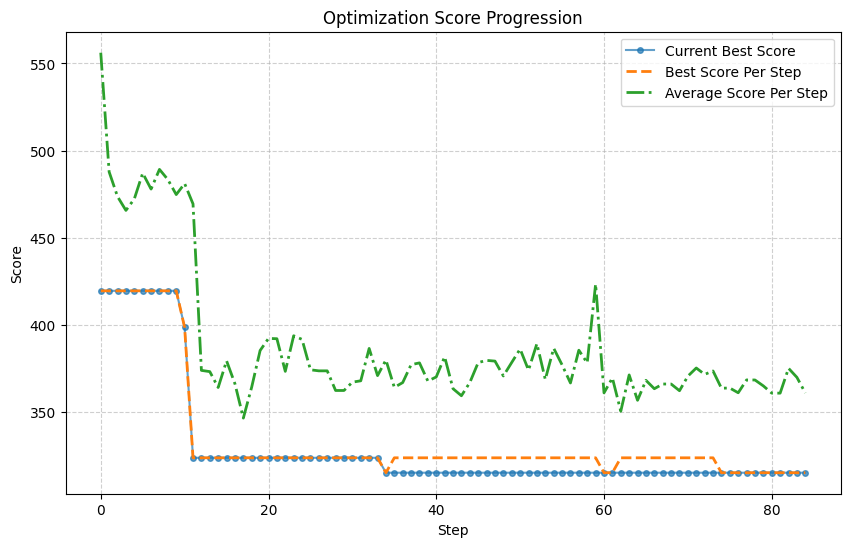

In [12]:
from llmize.utils.plotting import plot_scores

plot_scores(results)

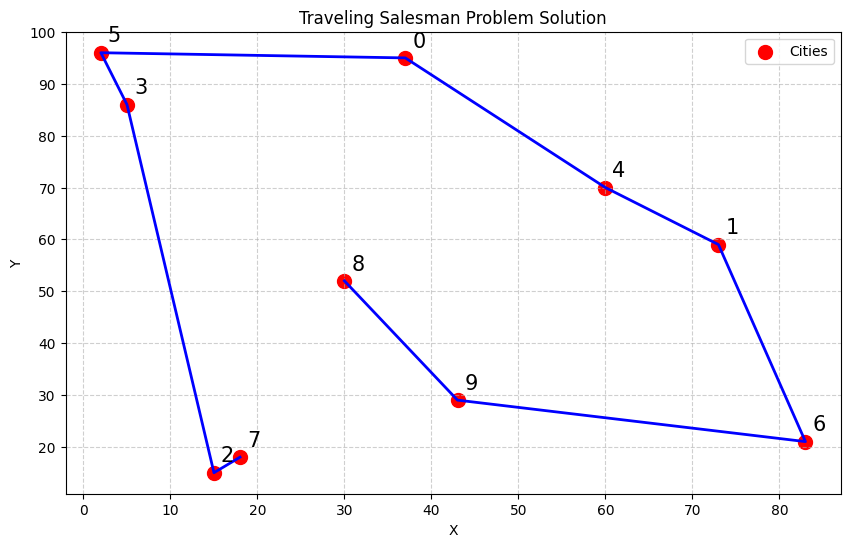

In [13]:
# Plot city coordinates along with traces from best solution
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='r', s=100, label='Cities')

solution = results['best_solution']
plt.plot(cities[solution, 0], cities[solution, 1], color='b', linewidth=2)

# Annotate city number a distance to the dots
for i, city in enumerate(cities):
    plt.annotate(str(i), xy=(city[0], city[1]), xytext=(5, 5),fontsize=15, textcoords='offset points', ha='left', va='bottom')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Traveling Salesman Problem Solution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [14]:
print(solution)

[7, 2, 3, 5, 0, 4, 1, 6, 9, 8]
